<a href="https://colab.research.google.com/github/ReemAlsharabi/KAUST-Academy/blob/main/summer-program/week1/gans/06_Colab_RockGAN2D_Berea(conv)_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock GAN (Berea dataset)- Tutorial

This notebook trains a Generative Adversarial Network (GAN) on rock images. The GAN consists of a Generator and a Discriminator model, both implemented as PyTorch modules. The Generator model generates new images from random noise, and the Discriminator model attempts to distinguish between real images from the CT scan and generated images. The models are trained in an adversarial manner, with the Generator trying to fool the Discriminator and the Discriminator trying to correctly classify real vs. fake.
This code is adapted from: https://github.com/sw-song/PyTorch-GAN/blob/master/implementations/gan/gan.py

## This Tutorial is for people using Colab

Download the following https://drive.google.com/drive/folders/1JgSlZdvByUJ44KT3lYb0CHAYP_HRaIK4?usp=sharing  and place all the files on your drive: creating a folder on your root /My Drive/rockgan_data/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np


import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from IPython.display import Image
import tifffile as tiff

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.optim import lr_scheduler

Setting the seed

**Why 42?** <br>
It is the  [Answer to the Ultimate Question of Life, the Universe, and Everything](https://en.wikipedia.org/wiki/Phrases_from_The_Hitchhiker%27s_Guide_to_the_Galaxy#Answer_to_the_Ultimate_Question_of_Life,_the_Universe,_and_Everything_(42)) 😆 !


In [3]:
def set_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f'Set seed {seed}')

set_seed(42)  # Use any number you like here

Set seed 42


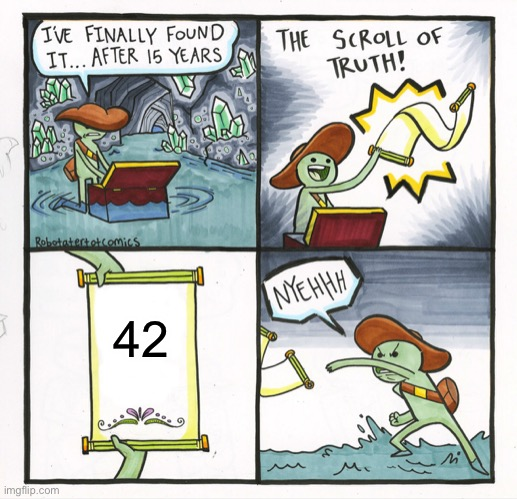

In [4]:
# Image(filename='../assets/42.jpeg')
Image(filename='/content/drive/My Drive/rockgan_data/42.jpeg')

## Set up training parameters
Instead of using an argument parser, we'll just set up all of the parameters as variables in the script. This is a more notebook-friendly approach.

In [5]:
# Define the parameters for the training process
n_epochs = 100
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
latent_dim = 64
img_size = 64
channels = 1

In [6]:
# Create a directory to save generated images
os.makedirs("06_berea_images_colab", exist_ok=True)

# Image dimensions
img_shape = (channels, img_size, img_size)

# Check if a GPU is available and if not, use a CPU
cuda = True if torch.cuda.is_available() else False

## Training Data

In [7]:
class CustomTensorDataset(Dataset): # dataloader
    """
    A custom Dataset class for loading tensors.
    """
    def __init__(self, tensor, transform=None):
        self.tensor = tensor
        self.transform = transform

    def __len__(self):
        return self.tensor.size(0)

    def __getitem__(self, index):
        sample = self.tensor[index]
        if self.transform:
            sample = self.transform(sample)
        return sample

#Loading the samples
# rock = tiff.imread('../data/berea/berea.tif')
# rock = tiff.imread('beadpack.tif')
rock= np.load('/content/drive/My Drive/rockgan_data/berea_numpy.npy')

#make subsamples
height, width = img_size, img_size

"""
prepare a set of image patches (windows) from a 3D numpy array rock representing an image
window_size specifies the desired size of each patch, which is typically smaller than the size of the original image.
"""
window_size = (height, width)  # Specify the desired window size
tensor_3d = torch.from_numpy(rock)  # Convert the 3D array to a PyTorch tensor
tensor_4d = tensor_3d.unsqueeze(0).unsqueeze(0)  # Add dimensions for batch and channels
windows = tensor_4d.unfold(2, window_size[0], window_size[0]).unfold(3, window_size[1], window_size[1])
windows = windows.reshape(-1, 1, window_size[0], window_size[1])/255  # Reshape the windows tensor
# windows = 1-windows

# Transform to apply to each sample (you can define any other transformations here)
transform = transforms.Compose([
    # Normalize tensors so that the pixel intensity values have a mean of 0.5 and a standard deviation of 0.5.
    transforms.Normalize([0.5], [0.5])
])

# Wrap the `windows` tensor in a custom Dataset
custom_dataset = CustomTensorDataset(windows, transform=transform)

# Create a DataLoader for your custom Dataset
batch_size = batch_size  # You can choose a different batch size if needed

dataloader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [8]:
num_samples = len(dataloader.dataset)
print(f'There are {num_samples} samples in the DataLoader.')

There are 14400 samples in the DataLoader.


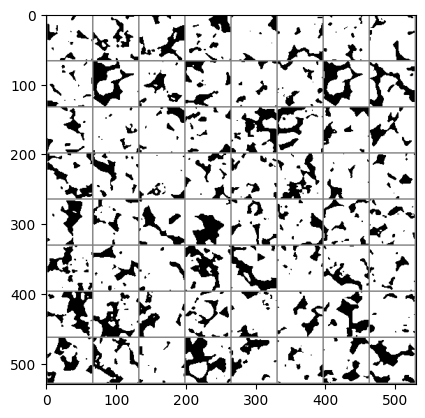

In [9]:
# Get a batch of images
dataiter = iter(dataloader)
images = next(dataiter)

# Function to unnormalize and bring back the pixel values to (0, 1)
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose to put channel last (which is the expected format for matplotlib)
    plt.show()

# Make a grid from the batch and show it
imshow(torchvision.utils.make_grid(images))

## Define the Generator and Discriminator models

We'll implement the Generator and Discriminator as PyTorch modules. The Generator will take in a noise vector and output an image, while the Discriminator will take in an image and output a probability indicating whether the image is real or fake.

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Function to create a convolutional transpose layer block (ConvTranspose -> InstanceNorm (optional) -> LeakyReLU)
        def block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, normalize=True):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        # (*) is used to unpack the output of the block() function, which returns a tuple of layers that are passed as arguments to nn.Sequential()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            *block(latent_dim, 512, 4, 1, 0, normalize=False),  # First layer block
            *block(512, 256, 4, 2, 1),  # Second layer block
            *block(256, 128, 4, 2, 1),  # Third layer block
            *block(128, 64, 4, 2, 1),  # Fourth layer block
            nn.ConvTranspose2d(64, channels, 4, 2, 1),  # Final Convolutional layer
            nn.Tanh()  # Tanh activation for output
        )

    def forward(self, z):  # Forward propagation function
        z = z.view(z.size(0), z.size(1), 1, 1)  # Reshape the input tensor in (B x C x H x W) format
        img = self.model(z)  # Pass input through the model
        return img  # Return the image


In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Function to create a convolutional layer block (Conv -> LeakyReLU)
        def block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
            return [
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.LeakyReLU(0.2, inplace=True)
            ]

        self.model = nn.Sequential(
            *block(channels, 64),  # First layer block
            *block(64, 128),  # Second layer block
            *block(128, 256),  # Third layer block
            *block(256, 512),  # Fourth layer block
            nn.Conv2d(512, 1, 4, 1, 0),  # Final convolutional layer
            nn.Sigmoid()  # Sigmoid activation for output
        )

    def forward(self, img):  # Forward propagation function
        validity = self.model(img)  # Pass the image through the model
        validity = validity.view(validity.size(0), -1)  # Flatten the output
        return validity  # Return the validity

Loss Function

In [12]:
# We use binary cross-entropy loss for the adversarial loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize the generator and the discriminator
generator = Generator()
discriminator = Discriminator()

# If CUDA is available, we use it for the models and the loss function
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()


# We use the Adam optimizer for both the generator and the discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))


# Initialize schedulers
scheduler_G = lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.1)
scheduler_D = lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.1)

#
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

## Training Loop

In [13]:
# Initialize list to store losses for Generator and Discriminator
g_losses = []
d_losses = []

# Training Loop
for epoch in tqdm(range(n_epochs)):  # Loop over the dataset multiple times, for each epoch
    g_loss_accum = 0.0
    d_loss_accum = 0.0
    num_batches = 0
    for i, (imgs) in enumerate(dataloader):  # Loop over each batch of real images in the dataset

        # Ground truths for real and fake images (real: 1, fake: 0)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input, this will be used for training the discriminator with real images
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()  # Clears the gradients of all optimized tensors
        # Sample noise as generator input
        """
        generates a batch of random noise vectors z that will be used as input to the generator network.
        The generator network then generates a batch of fake images gen_imgs from this noise.
        """
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))


        # zz = z.view(z.size(0), z.size(1), 1, 1)
        # print(zz.shape)

        # Generate a batch of images from the noise
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()  # Compute the gradient of g_loss w.r.t. the Generator's parameters
        optimizer_G.step()  # Update the Generator's weights


        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()  # Clears the gradients of all optimized tensors

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)  # Loss for real images
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)  # Loss for fake images
        d_loss = (real_loss + fake_loss) / 2  # Take the average of these two losses

        d_loss.backward()  # Compute the gradient of d_loss w.r.t. the Discriminator's parameters
        optimizer_D.step()  # Update the Discriminator's weights


        # Accumulate losses for this batch
        g_loss_accum += g_loss.item()
        d_loss_accum += d_loss.item()
        num_batches += 1

    # Step the learning rate
    scheduler_G.step()
    scheduler_D.step()

    # Save average losses for this epoch
    g_losses.append(g_loss_accum / num_batches)
    d_losses.append(d_loss_accum / num_batches)

    # Save a batch of generated images every 10 epochs
    if epoch % 10 == 0:
        save_image(gen_imgs.data[:25], f"06_berea_images_colab/epoch_{epoch}.png", nrow=5, normalize=True)


100%|██████████| 100/100 [34:03<00:00, 20.44s/it]


Plot the losses

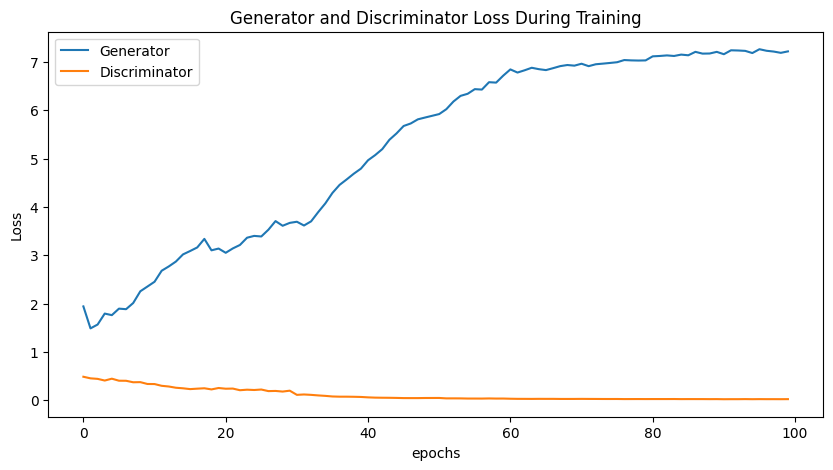

In [14]:
# Plotting the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="Generator")
plt.plot(d_losses,label="Discriminator")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Plot samples generated

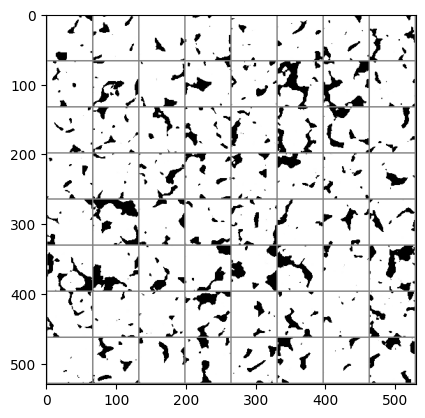

In [15]:
# Make a grid from the batch and show it (generated data)
imshow(torchvision.utils.make_grid(gen_imgs.detach().cpu()))

Let us look at the evolution

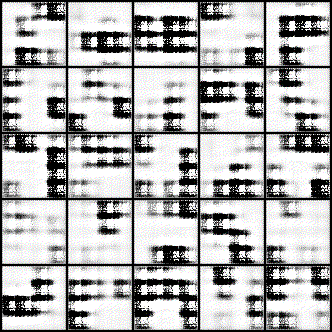

In [16]:
import os
import glob
from PIL import Image
from IPython.display import Image as IPyImage
from IPython.display import display

# Path to the folder containing the images
folder_path = "06_berea_images_colab/"

# Get a list of image file paths in the folder
image_files = sorted(glob.glob(os.path.join(folder_path, "*.png")))  # Replace "*.jpg" with the appropriate file extension

# Create a list to store the image objects
images = []

# Iterate over the image files and open each image
for image_file in image_files:
    image = Image.open(image_file)
    images.append(image)

# Save the images as a GIF file
output_path = "06_berea_images_colab/output.gif"
images[0].save(output_path, save_all=True, append_images=images[1:], duration=500, loop=0)

# Display the GIF
display(IPyImage(filename=output_path))
